In [8]:
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

## Setting up arguments

In [53]:
args = Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=2, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.0001, mixing='concat', mse_weight=0.0, n=2000, net='hetvae', 
                 niters=20, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

# original
args = Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.0001, mixing='concat', mse_weight=0.0, n=2000, net='hetvae', 
                 niters=2000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [1]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

NameError: name 'args' is not defined

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [45]:
data_obj = utils.get_synthetic_data(args)
train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
val_loader = data_obj["val_dataloader"]
gt = data_obj['ground_truth']
dim = data_obj["input_dim"]
union_tp = utils.union_time(train_loader)

(2000, 51, 3)
(1600, 51, 3) (320, 51, 3) (400, 51, 3)


In [7]:
# use Josh synthethic data
from toy_dataset import data_utils

name = 'toydataset_50000'
path = data_utils.datasets_dict[name]
dataset = data_utils.ToyDataDf(path)
dataset.create_mcar_missingness(0.3, -1)
model_args = '--niters 2000 --lr 0.0001 --batch-size 128 --rec-hidden 16 --latent-dim 64 --embed-time 128 --enc-num-heads 1 --num-ref-points 16 --n 2000 --dataset toy --seed 0 --norm --sample-tp 0.5 --k-iwae 1'.split()
train_dataloader, validation_dataloader = dataset.prepare_mtan(model_args=model_args, batch_size=128)

--
Created MCAR missing data, but without missingness in columns Index(['id', 'time'], dtype='object')
missingness_rate: 0.3,	missingness_value: -1
Missing values: 0 out of 500000 (0.0%) (!excluding aforementioned columns)
Data values in entire dataframe is 750000 (shape: (125000, 6))
Using batch size 128 for training and validation set.
parameters encoder/decoder: 44610 83178
Logging and saving model to:  ./imputation/runs/mTANtoy/2023.01.05-14.00.42/


In [8]:
train_loader = train_dataloader
val_loader = validation_dataloader
test_loader = validation_dataloader
union_tp = utils.union_time(train_loader)
dim = 4

In [9]:
j = iter(train_loader)
k = next(j)
print(k.shape)
print("observed data:", k[0,:,2])

torch.Size([128, 50, 9])
observed data: tensor([-1.0000,  0.2937,  0.4480,  0.6108, -1.0000,  0.7614,  0.7516,  0.5800,
         0.4220,  0.2959,  0.1714, -1.0000,  0.3905, -1.0000,  0.7275, -1.0000,
         0.7600,  0.6692,  0.5025,  0.3399, -1.0000,  0.2216,  0.2954,  0.4497,
         0.6466,  0.8090, -1.0000,  0.7296,  0.5832,  0.3935,  0.2425,  0.2150,
         0.2507,  0.3905, -1.0000,  0.7344, -1.0000,  0.7877,  0.6629,  0.4857,
        -1.0000,  0.2086, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.8064,
        -1.0000,  0.5882])


## **Loading HeTVAE model**

In [56]:
net = models.load_network(args, dim, union_tp)
params = list(net.parameters())
optimizer = optim.Adam(params, lr=args.lr)

## **Training**

In [57]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for train_batch in train_loader:
          batch_len = train_batch.shape[0]
          train_batch = train_batch.to(device)
          subsampled_mask = torch.zeros_like(
              train_batch[:, :, dim:2 * dim]).to(device)
          seqlen = train_batch.size(1)
          for i in range(batch_len):
              length = np.random.randint(low=3, high=10)
              obs_points = np.sort(
                  np.random.choice(np.arange(seqlen), size=length, replace=False)
              )
              subsampled_mask[i, obs_points, :] = 1
          recon_mask = train_batch[:, :, dim:2 * dim] - subsampled_mask
          context_y = torch.cat((
              train_batch[:, :, :dim] * subsampled_mask, subsampled_mask
          ), -1)

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, -1],
              context_y,
              train_batch[:, :, -1],
              torch.cat((
                  train_batch[:, :, :dim] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae,
              beta=1,
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      if itr % 10 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
          for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
              utils.evaluate_hetvae(
                  net,
                  dim,
                  loader,
                  0.5,
                  shuffle=False,
                  k_iwae=num_samples,
                #   model_name=args.net,
              )
              

Iter: 10, train loss: 1.0373, avg nll: 1.0330, avg kl: 0.0043, mse: 0.462555, mae: 0.539982
nll: 1.0123, mse: 0.4455, mae: 0.5299, mean_mse: 0.4440, mean_mae: 0.5289
nll: 1.0213, mse: 0.4533, mae: 0.5357, mean_mse: 0.4514, mean_mae: 0.5345
Iter: 20, train loss: 1.0298, avg nll: 1.0290, avg kl: 0.0008, mse: 0.460227, mae: 0.539388
nll: 1.0062, mse: 0.4401, mae: 0.5264, mean_mse: 0.4393, mean_mae: 0.5258
nll: 1.0159, mse: 0.4477, mae: 0.5323, mean_mse: 0.4466, mean_mae: 0.5317
Iter: 30, train loss: 1.0281, avg nll: 1.0277, avg kl: 0.0004, mse: 0.459405, mae: 0.538831
nll: 1.0049, mse: 0.4392, mae: 0.5258, mean_mse: 0.4387, mean_mae: 0.5255
nll: 1.0151, mse: 0.4464, mae: 0.5316, mean_mse: 0.4459, mean_mae: 0.5313
Iter: 40, train loss: 0.9938, avg nll: 0.9914, avg kl: 0.0025, mse: 0.428676, mae: 0.518132
nll: 0.9404, mse: 0.3871, mae: 0.4944, mean_mse: 0.3860, mean_mae: 0.4937
nll: 0.9437, mse: 0.3878, mae: 0.4949, mean_mse: 0.3865, mean_mae: 0.4941
Iter: 50, train loss: 0.9758, avg nll: 0

KeyboardInterrupt: 

In [62]:
# Visualization JOSH

# get data
batch = next(iter(val_loader))
sample = 3
feature = 0
x_observed = batch[sample,:,feature].cpu()
x_mask = batch[sample, :, feature+1].cpu()
x_time = batch[sample, :, -1].cpu()

# impute data
train_batch = batch
batch_len = train_batch.shape[0]
train_batch = train_batch.to(device)
subsampled_mask = torch.zeros_like(
    train_batch[:, :, dim:2 * dim]).to(device)
seqlen = train_batch.size(1)
for i in range(batch_len):
    length = np.random.randint(low=3, high=10)
    obs_points = np.sort(
        np.random.choice(np.arange(seqlen), size=length, replace=False)
    )
    subsampled_mask[i, obs_points, :] = 1
recon_mask = train_batch[:, :, dim:2 * dim] - subsampled_mask
context_y = torch.cat((
    train_batch[:, :, :dim] * subsampled_mask, subsampled_mask
), -1)
px, qz = net.get_reconstruction(train_batch[:, :, -1],
                                context_y,
                                train_batch[:, :, -1],
                                num_samples=100)
x_predicted = px.mean[0, sample, :, feature].cpu().detach().numpy()
x_logvar = px.logvar[0, sample, :, feature].cpu().detach().numpy()

# visualize data
fig = plt.figure()
plt.scatter(x_time, x_observed, alpha=0.5, label='observed')
plt.scatter(x_time, x_predicted, alpha=0.5, label='predicted')
# plt.fill_between(x_time, x_predicted+x_logvar, x_predicted-x_logvar, alpha=0.5, color='grey', label='logvar')
plt.legend() 
plt.show()
torch.cuda.empty_cache()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.98 GiB (GPU 0; 23.70 GiB total capacity; 21.64 GiB already allocated; 244.12 MiB free; 21.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## **Vizualization with increasing number of observations**

In [58]:
def viz(test_loader, k_iwae=1, n_max=20):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for low in [3, 10, 20]:
            for batch in test_loader:
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                seqlen = batch.size(1)
                for i in range(batch_len):
                    length = np.random.randint(low=low, high=low + 1)
                    obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                    subsampled_mask[i, obs_points, :] = 1
                recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, -1], context_y, batch[:, :, -1], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, :dim]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, -1].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print('pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape')
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    print('preds.shape:', preds.shape)
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    print('preds.shape:', preds.shape)
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    print('median.shape:', median.shape)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)

    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()
    torch.cuda.empty_cache()
    

pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape
(100, 60, 51, 1) (100, 60, 51, 1) (60, 51, 1) (60, 51, 1) (60, 51)
preds.shape: (50, 100, 60, 51, 1)
preds.shape: (5000, 60, 51, 1)
median.shape: (60, 51, 1)


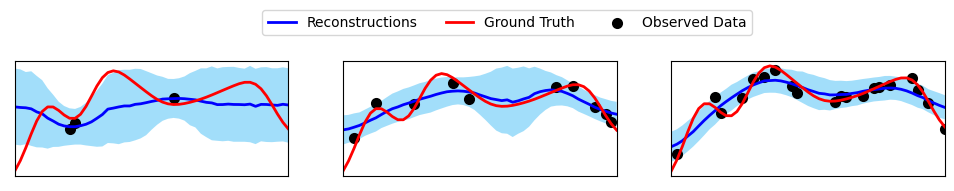

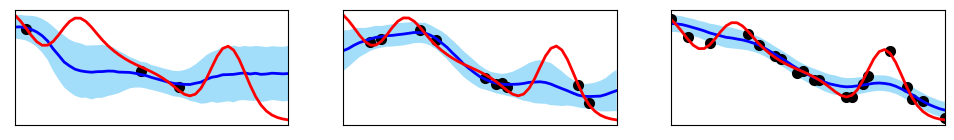

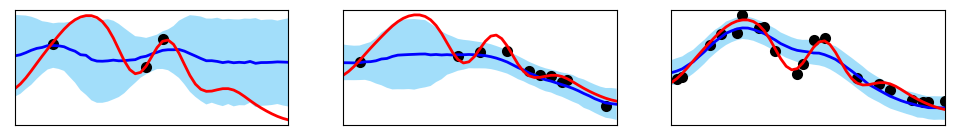

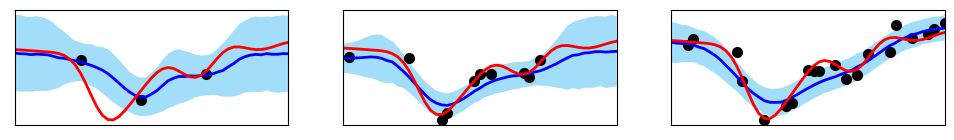

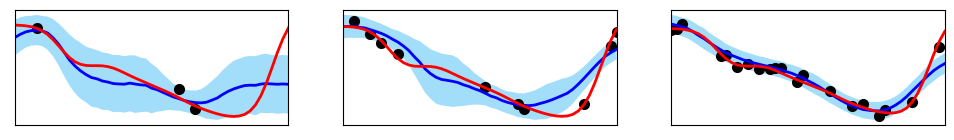

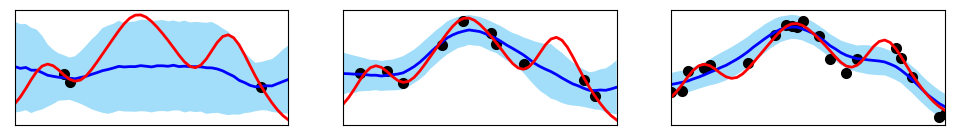

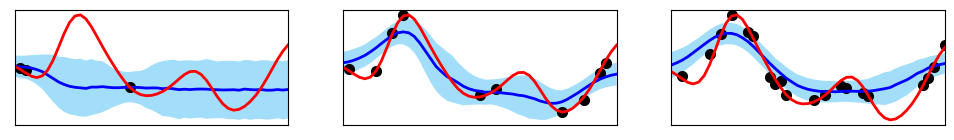

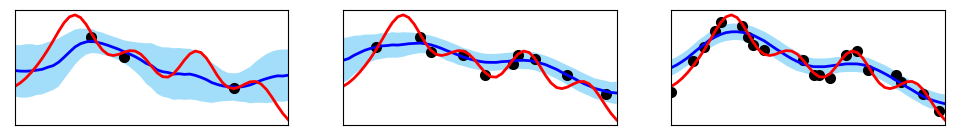

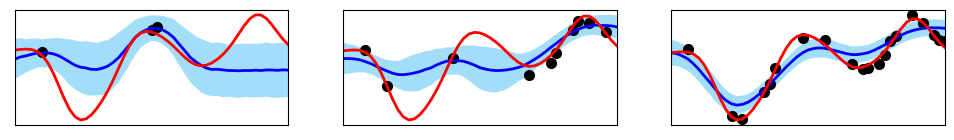

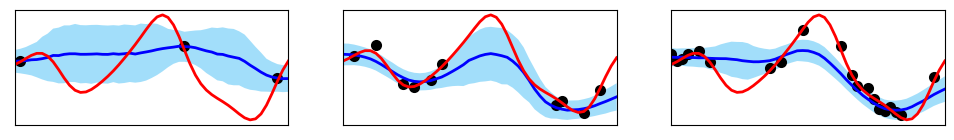

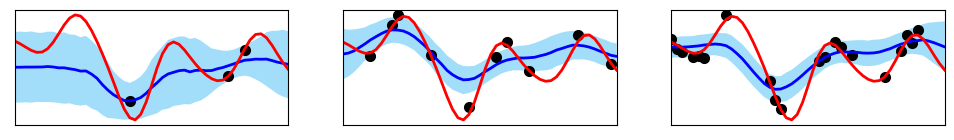

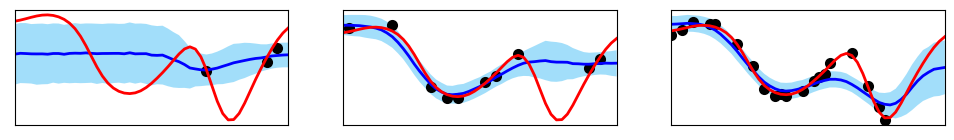

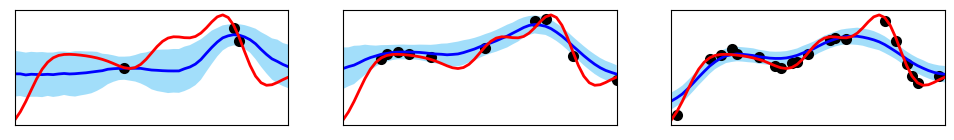

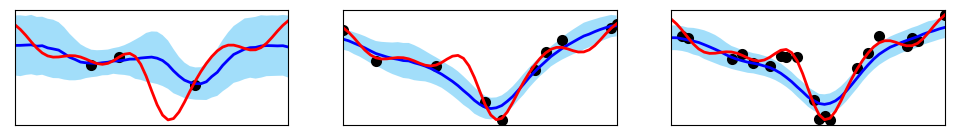

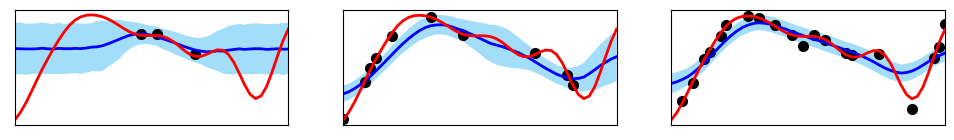

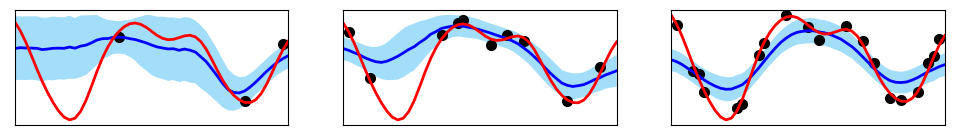

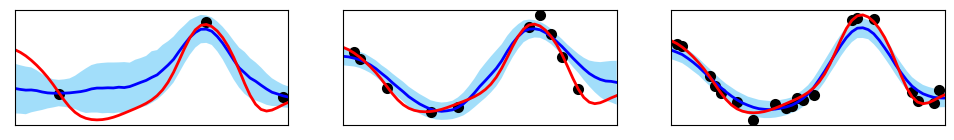

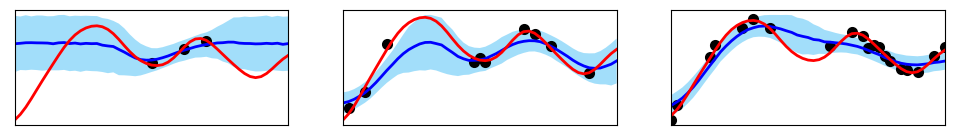

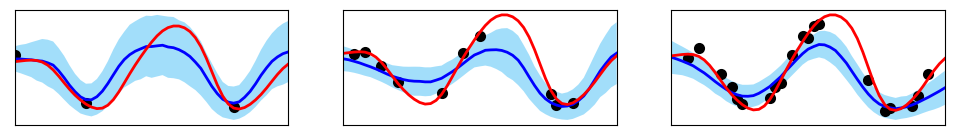

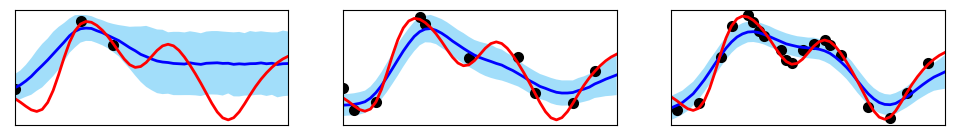

In [59]:
viz(test_loader, k_iwae=100)

# Using HETVAE as an object

In [1]:
from imputation.hetvae.src.train import HETVAE
from toy_dataset import data_utils
import utils


### Get Dataloader

In [2]:
# load my own synthetic data (Josh)
from toy_dataset import data_utils
name = 'toydataset_50000'
path = data_utils.datasets_dict[name]
dataset = data_utils.ToyDataDf(path)
dataset.create_mcar_missingness(0.2, -1)
model_args = '--niters 2000 --lr 0.0001 --batch-size 128 --rec-hidden 16 --latent-dim 64 --embed-time 128 --enc-num-heads 1 --num-ref-points 16 --n 2000 --dataset toy --seed 0 --norm --sample-tp 0.5 --k-iwae 1'.split()
train_dataloader, validation_dataloader = dataset.prepare_mtan(model_args=model_args, batch_size=256)

# modify, so that my own (Josh) data is used instead of the HETVAE author's data
train_loader = train_dataloader
val_loader = validation_dataloader
test_loader = validation_dataloader
union_tp = utils.union_time(train_loader)
dim = 4

--
Created MCAR missing data, but without missingness in columns Index(['id', 'time'], dtype='object')
missingness_rate: 0.2,	missingness_value: -1
Missing values: 0 out of 4000000 (0.0%) (!excluding aforementioned columns)
Data values in entire dataframe is 6000000 (shape: (1000000, 6))
Using batch size 256 for training and validation set.
parameters encoder/decoder: 44610 83178
Logging and saving model to:  ./imputation/runs/mTANtoy/2023.01.21-20.11.39/


In [ ]:
model_args = '--niters 300 --lr 0.001 --batch-size 128 --rec-hidden 128 --latent-dim 128 --width 128 --embed-time 128 --enc-num-heads 1 --num-ref-points 16 --n 8000 --dataset toy-josh --seed 1 --save --norm --intensity --net hetvae --bound-variance --sample-tp 0.85 --elbo-weight 1.0 --mse-weight 35 --mixing concat --k-iwae 10'
hetvae = HETVAE(dim, union_tp, model_args)

In [ ]:
path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.17-18.25.58/hetvae.h5'
log_path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.17-18.25.58/'

hetvae.load_from_checkpoint(path, log_path)

In [ ]:
hetvae.train_model(train_loader, val_loader)

# Impute and Visualize

### Impute

In [57]:
# get data
batch = next(iter(train_loader))
pred_mean, preds, quantile_low, quantile_high = hetvae.impute(batch, 100, sample_tp=0.9)
print(f'Batch size: {batch.shape}')
print(f'pred_mean: {pred_mean.shape}')
print(f'preds: {preds.shape}')
print(f'quantile_low: {quantile_low.shape}')
print(f'quantile_high: {quantile_high.shape}')

Batch size: torch.Size([256, 50, 9])
pred_mean: (256, 50, 4)
preds: (50, 256, 50, 4)
quantile_low: (256, 50, 4)
quantile_high: (256, 50, 4)


### Visualize a sample

torch.Size([50, 9])
torch.Size([49, 9])


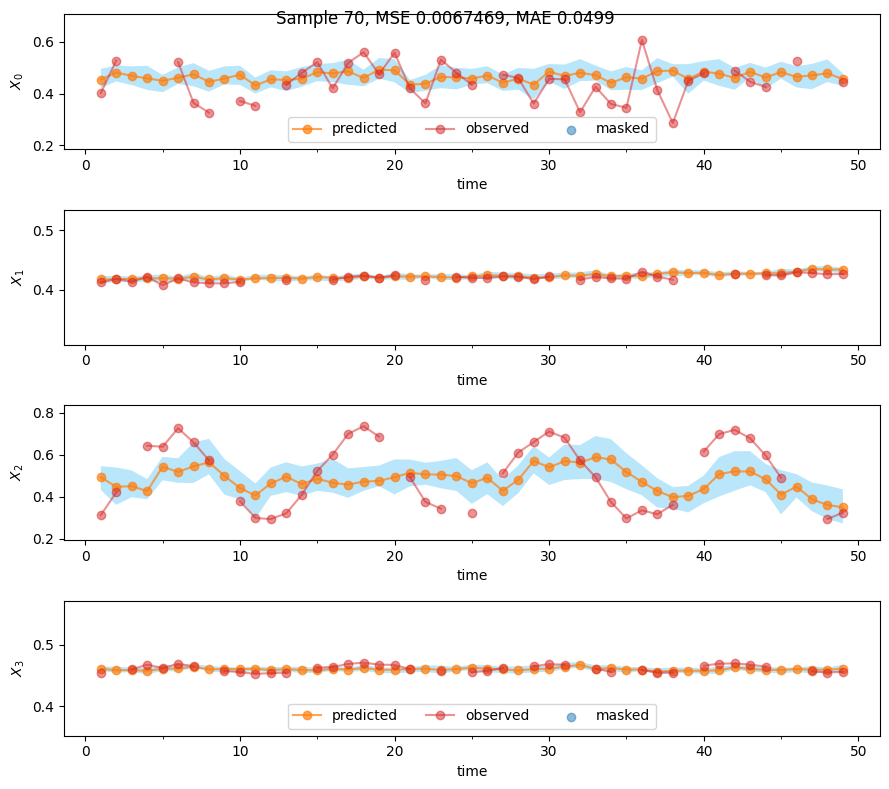

In [61]:
utils.visualize_sample(batch, pred_mean, quantile_low, quantile_high, sample=70)
# utils.visualize_sample(dim, batch, pred_mean)
# utils.visualize_sample(dim, batch, pred_mean)

# Is HeTVAE invariant to the values of the missing data?

> Remember: mTAN was **NOT** invariant of the value given to the missing data, eventhough it should not make any differece.

To see if HeTVAE is any different we compare the imputed results of
+ unobserved (=masked) data value of -1 
+ unobserved (=masked) data value of 999

Even, if the model is invariant to these values, it is expected to give slightly different values, as we are drawing from prob. distributions.
> Or could we just compare the means themselves???


### Let's compare visually first

torch.Size([256, 50, 9])


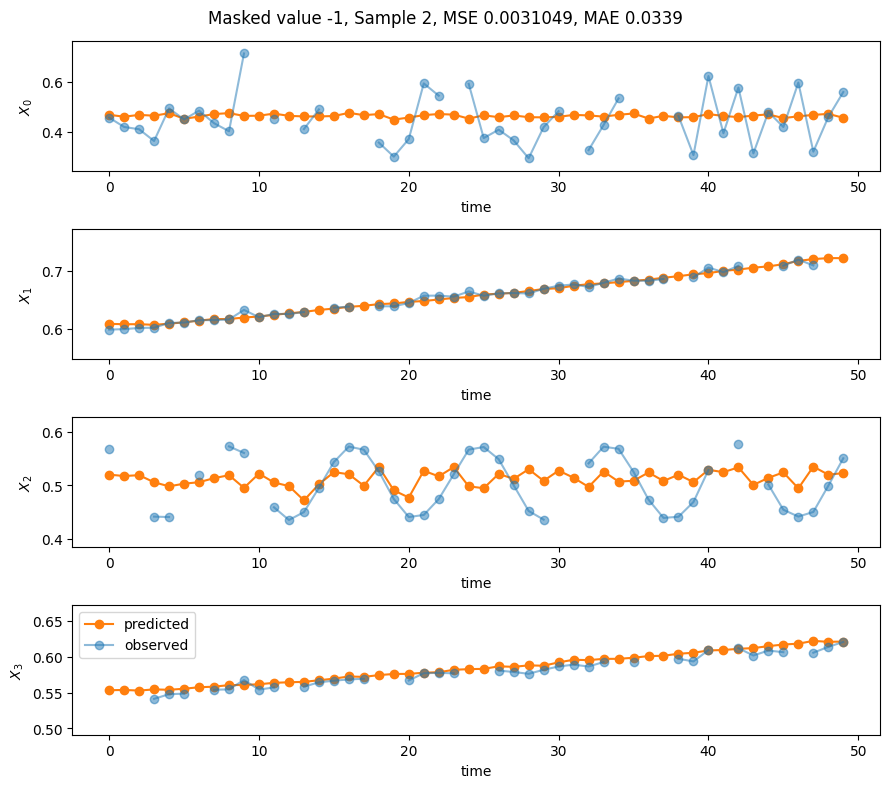

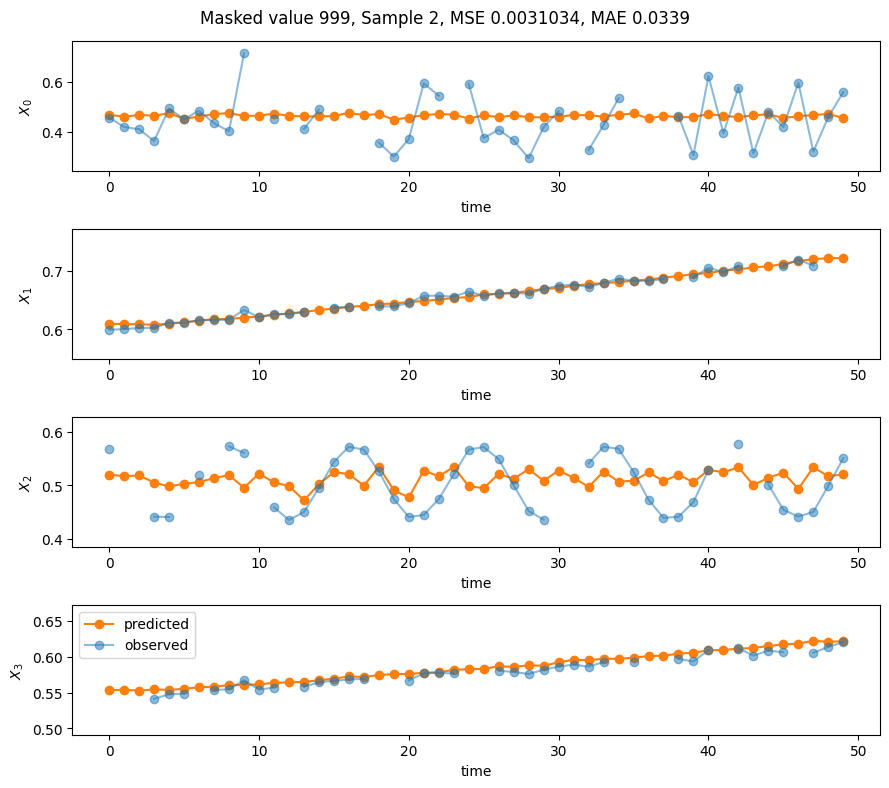

In [11]:
# masked value of -1
batch = next(iter(train_loader))
# batch = batch[:3,...]
print(batch.shape)
batch_m1 = batch.clone()
pred_mean_m1, pred_std_m1, quantile_low, quantile_high = hetvae.impute(batch_m1, 200)

# masked value of 999
batch_999 = batch.clone()
batch_999_mask = batch_999[:,:,dim:2*dim]
batch_999_mask[batch_999_mask == -1] = 999 
pred_mean_999, pred_std_999, quantile_low, quantile_high = hetvae.impute(batch_999, 200)

# visualize
sample = np.random.randint(0,batch.shape[0])
utils.visualize_sample(batch_m1, pred_mean_m1, title='Masked value -1, ', sample=sample)
utils.visualize_sample(batch_999, pred_mean_999, title='Masked value 999, ', sample=sample)

### Now let us compare computationally

We iterate over the entire dataset and then compare.

In [3]:
def compute_loss_manually(model:HETVAE, data_loader:torch.utils.data.DataLoader, num_samples=1):
    dim = model.n_features
    mse, mae = 0, 0
    for batch in tqdm(data_loader):
        pred_mean, pred_std, quantile_low, quantile_high = model.impute(batch, num_samples)
        # pred_mean = pred_mean.squeeze()
        x_observed = batch[:,:,:dim]
        x_mask = batch[:,:,dim:2*dim]
        # assert(x_observed.shape == pred_mean.shape), f'x_observed.shape {x_observed.shape} != pred_mean.shape {pred_mean.shape}'
        mse += utils.mean_squared_error(x_observed, pred_mean, x_mask)
        mae += utils.mean_absolute_error(x_observed, pred_mean, x_mask) 

    mse /= (len(data_loader) * data_loader.batch_size)
    mae /= (len(data_loader) * data_loader.batch_size)

    return mse, mae

NameError: name 'torch' is not defined

In [18]:
mse, mae = compute_loss_manually(hetvae, val_loader, 10)
print(f'mse: ', mse)
print(f'mae: ', mae)

100%|██████████| 10/10 [00:08<00:00,  1.17it/s]

mse:  tensor(4.0225e-05, dtype=torch.float64)
mae:  tensor(0.0002, dtype=torch.float64)


# TESTING HETVAE TRAINED LIKE PHYSIONET BUT ON SYNTHETIC DATA

In [3]:
## testing out hetvae trained like physionet
dataset_name = 'toy-josh'
model_args = f'--niters 1000 --lr 0.0001 --batch-size 128 --rec-hidden 128 --latent-dim 128 --width 128 --embed-time 128 --enc-num-heads 1 --num-ref-points 16 --n 8000 --dataset {dataset_name} --seed 1 --save --norm --intensity --net hetvae --bound-variance --shuffle  --sample-tp 0.5 --elbo-weight 1.0 --mse-weight 5.0 --mixing concat --k-iwae 5'



hetvae = HETVAE(dim, union_tp, model_args)

path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.18-18.43.54/hetvae.h5'
log_path = '/home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.18-18.43.54/'

hetvae.load_from_checkpoint(path, log_path)

Model args: Namespace(batch_size=128, bound_variance=True, const_var=False, dataset='toy-josh', dropout=0.0, elbo_weight=1.0, embed_time=128, enc_num_heads=1, fname=None, intensity=True, k_iwae=5, kl_annealing=False, kl_zero=False, latent_dim=128, lr=0.0001, mixing='concat', mse_weight=5.0, n=8000, net='hetvae', niters=1000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=128, recon_loss=False, sample_tp=0.5, save=True, seed=1, shuffle=True, std=0.1, var_per_dim=False, width=128)
Logging and saving model to: /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.21-20.12.29
self.device: cuda
parameters: 153352
Tensorboard logging to: /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.21-20.12.29

Loading model from  /home2/joshua.wendland/Documents/sepsis/imputation/runs/toy-josh/hetvae/2023.01.18-18.43.54/hetvae.h5
Loading saved weights done. Model trained until epoch  1499
Tensorboard logging to: /home2/joshua.we

torch.Size([50, 9])
torch.Size([49, 9])


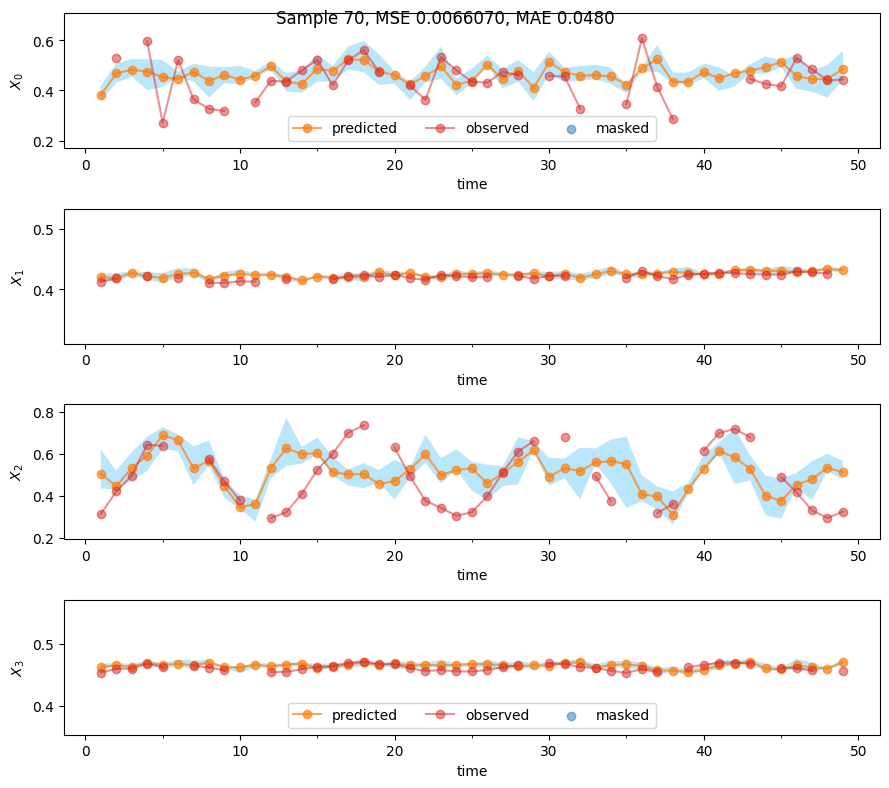

In [4]:
# get data
batch = next(iter(train_loader)) 
ground_truth_batch, training_batch = data_utils.get_batch_train_ground_truth(train_loader, dataset, batch_num=0)
pred_mean, preds, quantile_low, quantile_high = hetvae.impute(batch, 100, sample_tp=1)
utils.visualize_sample(batch, pred_mean, quantile_low, quantile_high, sample=70)


ground_truth_batch.shape (256, 50, 4)
training_batch.shape torch.Size([256, 50, 9])


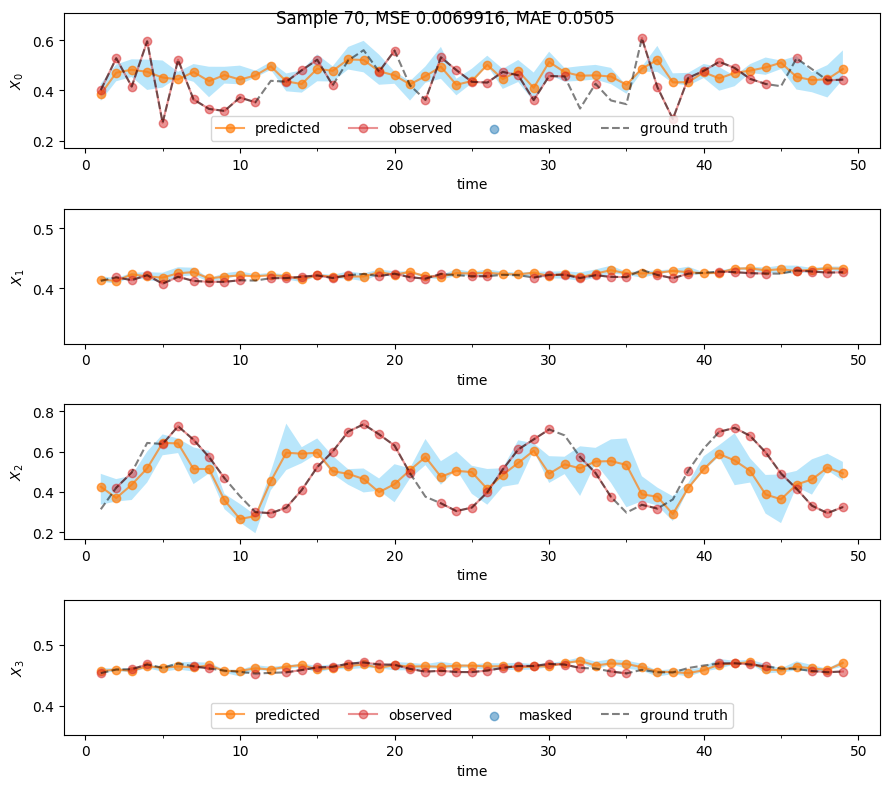

In [14]:
print('ground_truth_batch.shape', ground_truth_batch.shape)
print('training_batch.shape', training_batch.shape)
pred_mean, preds, quantile_low, quantile_high = hetvae.impute(training_batch, 100, sample_tp=1)
utils.visualize_sample(training_batch, pred_mean, quantile_low, quantile_high, ground_truth_batch, sample=70)


## Look at the influence of the augmented loss

By setting the weight of the augmented loss to different values, we figure out, which is the most suitable one. It acts as a regularization hyperparameter.

If not stated differently, all models were trained until epoch 1500.
The values for each experiment setting (each lambda) were taken from the corresponding tensorboard event logging files.

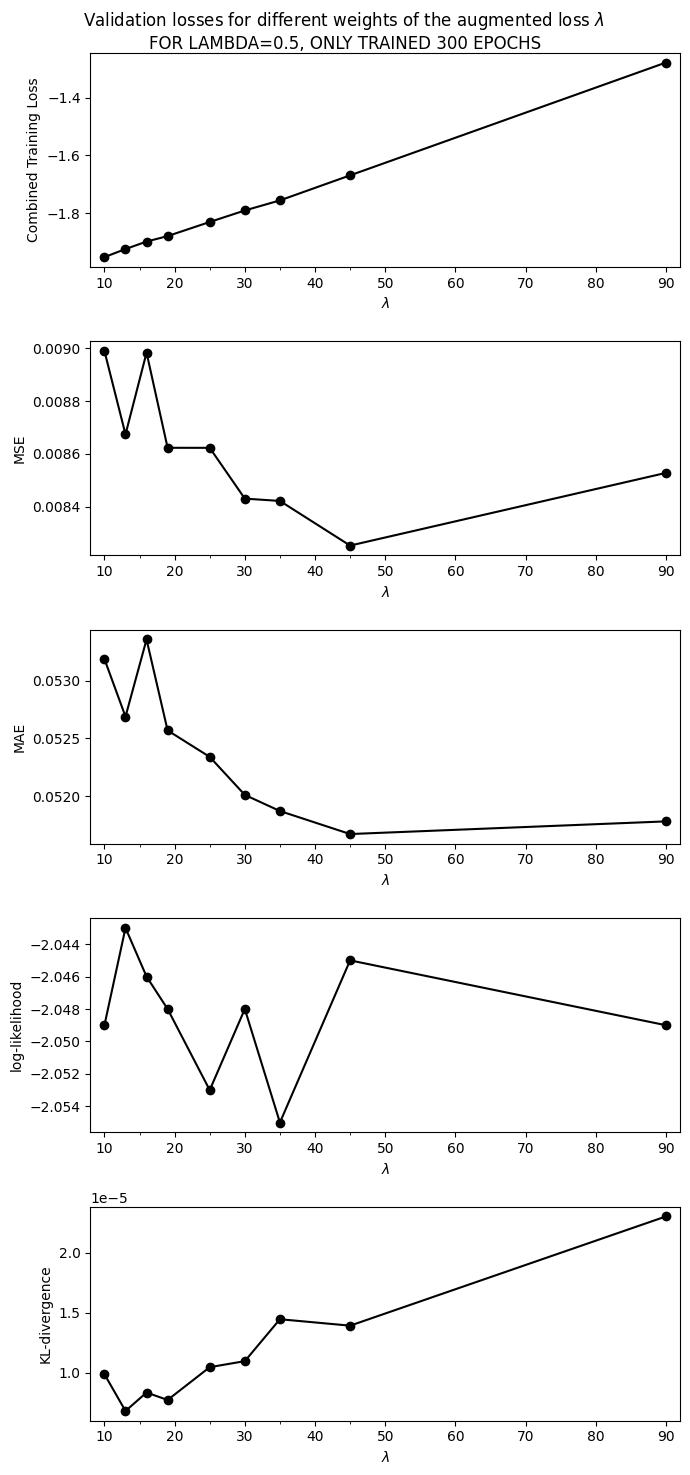

In [3]:
loss_weights = [10, 13, 16, 19, 25, 30, 35, 45, 90]
loss_total = [-1.953, -1.925, -1.899, -1.88, -1.831, -1.791, -1.756, -1.669, -1.277]
loss_maes = [0.05319, 0.05269, 0.05336, 0.05257, 0.05234, 0.05201, 0.05187, 0.05167, 0.05178]
loss_mses = [8.9896e-3, 8.6736e-3, 8.9834e-3, 8.6229e-3, 8.6227E-3, 8.4303e-3, 8.4215e-3, 8.2524e-3, 8.5278e-3]
loss_kl = [9.8618e-6, 6.7888e-6, 8.3319e-6, 7.7092e-6, 1.0451e-5, 1.0953e-5, 1.4456e-5, 1.3919e-5, 2.30465e-5]
loss_loglik = [-2.049, -2.043, -2.046, -2.048, -2.053, -2.048, -2.055, -2.045, -2.049]



losses = [loss_total, loss_mses, loss_maes, loss_loglik, loss_kl]
names = ['Combined Training Loss', 'MSE', 'MAE', 'log-likelihood', 'KL-divergence']

fig = plt.figure(figsize=(7, len(losses)*3))
for i, (loss, name) in enumerate(zip(losses, names)):
    ax = fig.add_subplot(len(losses), 1, i+1)
    plt.plot(loss_weights, loss, marker='o', c='black')
    plt.xlabel('$\lambda$')
    plt.ylabel(name)
    ax.set_xticks(np.arange(0,50,5), minor=True)
    ax.set_xlim((np.min(loss_weights)-2, np.max(loss_weights)+2))
    
fig.suptitle('Validation losses for different weights of the augmented loss $\lambda$ \nFOR LAMBDA=0.5, ONLY TRAINED 300 EPOCHS')
plt.tight_layout()
plt.show()
    